## CLEFIA CPA Attack

```
Conduct Correlation Power Analysis attacks at the first, second and last rounds of CLEFIA-128 encryption. 

Authors: Arjun Menon V (ee18b104), Akilesh Kannan (ee18b122)

Assignment 2, Secure Processor Microarchitecture

August 2022
```

**The iPython notebook and the data files are available on [this Github Repository](https://github.com/aklsh/CS6630)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tnrange
from scipy.stats import linregress
import seaborn as sns
import time
import rich as r
import pandas as pd
from IPython.display import clear_output # type: ignore
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import brewer

In [2]:
# Load input and power trace
textInp = np.load("../trace_002/textin_array.npy", "r")
powerTrace = np.load("../trace_002/trace_array.npy", "r")
cipherText = np.load("../trace_002/textout_array.npy", "r")
#
s0Arr = np.load("../data/s0.npy", "r")
s1Arr = np.load("../data/s1.npy", "r")
#
tf00Arr = np.load("../data/tf00.npy", "r")
tf01Arr = np.load("../data/tf01.npy", "r")
tf02Arr = np.load("../data/tf02.npy", "r")
tf03Arr = np.load("../data/tf03.npy", "r")
#
tf10Arr = np.load("../data/tf10.npy", "r")
tf11Arr = np.load("../data/tf11.npy", "r")
tf12Arr = np.load("../data/tf12.npy", "r")
tf13Arr = np.load("../data/tf13.npy", "r")

print(textInp.shape)
print(powerTrace.shape)

(12000, 16)
(12000, 18000)


In [3]:
# Split the 8 T-Tables into four, each holding a byte of the result. In all there are 32 T-Tables

tf000Arr = np.array([val & 0xFF for val in tf00Arr])
tf001Arr = np.array([(val & 0xFF00)>>8 for val in tf00Arr])
tf002Arr = np.array([(val & 0xFF0000)>>16 for val in tf00Arr])
tf003Arr = np.array([(val & 0xFF000000)>>24 for val in tf00Arr])

tf010Arr = np.array([val & 0xFF for val in tf01Arr])
tf011Arr = np.array([(val & 0xFF00)>>8 for val in tf01Arr])
tf012Arr = np.array([(val & 0xFF0000)>>16 for val in tf01Arr])
tf013Arr = np.array([(val & 0xFF000000)>>24 for val in tf01Arr])

tf020Arr = np.array([val & 0xFF for val in tf02Arr])
tf021Arr = np.array([(val & 0xFF00)>>8 for val in tf02Arr])
tf022Arr = np.array([(val & 0xFF0000)>>16 for val in tf02Arr])
tf023Arr = np.array([(val & 0xFF000000)>>24 for val in tf02Arr])

tf030Arr = np.array([val & 0xFF for val in tf03Arr])
tf031Arr = np.array([(val & 0xFF00)>>8 for val in tf03Arr])
tf032Arr = np.array([(val & 0xFF0000)>>16 for val in tf03Arr])
tf033Arr = np.array([(val & 0xFF000000)>>24 for val in tf03Arr])


tf100Arr = np.array([val & 0xFF for val in tf10Arr])
tf101Arr = np.array([(val & 0xFF00)>>8 for val in tf10Arr])
tf102Arr = np.array([(val & 0xFF0000)>>16 for val in tf10Arr])
tf103Arr = np.array([(val & 0xFF000000)>>24 for val in tf10Arr])

tf110Arr = np.array([val & 0xFF for val in tf11Arr])
tf111Arr = np.array([(val & 0xFF00)>>8 for val in tf11Arr])
tf112Arr = np.array([(val & 0xFF0000)>>16 for val in tf11Arr])
tf113Arr = np.array([(val & 0xFF000000)>>24 for val in tf11Arr])

tf120Arr = np.array([val & 0xFF for val in tf12Arr])
tf121Arr = np.array([(val & 0xFF00)>>8 for val in tf12Arr])
tf122Arr = np.array([(val & 0xFF0000)>>16 for val in tf12Arr])
tf123Arr = np.array([(val & 0xFF000000)>>24 for val in tf12Arr])

tf130Arr = np.array([val & 0xFF for val in tf13Arr])
tf131Arr = np.array([(val & 0xFF00)>>8 for val in tf13Arr])
tf132Arr = np.array([(val & 0xFF0000)>>16 for val in tf13Arr])
tf133Arr = np.array([(val & 0xFF000000)>>24 for val in tf13Arr])

In [4]:
# Visualize Power Trace:
p = figure(plot_width=1000, plot_height=400)
idx = np.random.randint(0, powerTrace.shape[0])
p.line(range(0, len(powerTrace[idx])), powerTrace[idx])
show(p)

### Where do you take the Intermediate Result?

![image](../figs/firstRound.drawio.png)

We consider two choices for the location of the Intermediate Result (highlighted in the figure), used for correlating against the Power Trace:
- Output of the S-Box operation in the F0/1 function
- Output of the T-tables in the F0/1 function

The results show that taking the Intermediate Result out at the S-Box gives higher correlation and Confidence Scores, than when it is taken out at the T-tables.

### CPA at the SBox Output

**First Round of CLEFIA:**

PT = P0 | P1 | P2 | P3

T => P0 | P1 ^ WK0 | P2 | P3 ^ WK1

T => P0 ^ RK0 | P1 ^ WK0 | P2 ^ RK1 | P3 ^ WK1

T => S0(P0 ^ RK0) | P1 ^ WK0 | S1(P2 ^ RK1) | P3 ^ WK1  ---> Intermediate Result

P0 ^ RK0 sent to S0 function and P2 ^ RK1 to S1 bytewise, and the HW of the results are correlated against the power trace. To find WK's, the intermediate result used is $P_{2i + 1}$ ^ $WK_i$

**Last Round of CLEFIA:**
A similar approach is extended to the first round of decryption, to extract the round-keys used in the last round of CLEFIA encrpytion. By feeding in the cipher-text and the round key guesses to the S-Box operation, and correlating the Hamming Weight of the Intermediate Result against the power trace of the last round of encryption, we can get a clear distinguisher for the correct key guess. 

**Second Round of CLEFIA:**
The intermediate result for the Second Round of CLEFIA is computed as the S-Box output or the T-table output of the second round of encryption. The input to the S-Box in the second round is computed based on the round keys guessed from the First Round attack.

In [5]:
# Helper functions to compute the Intermediate Results
def s0(inp):
    return s0Arr[inp]
def s1(inp):
    return s1Arr[inp]

def tf00(inp):
    return tf00Arr[inp]
def tf01(inp):
    return tf01Arr[inp]
def tf02(inp):
    return tf02Arr[inp]
def tf03(inp):
    return tf03Arr[inp]

def tf10(inp):
    return tf10Arr[inp]
def tf11(inp):
    return tf11Arr[inp]
def tf12(inp):
    return tf12Arr[inp]
def tf13(inp):
    return tf13Arr[inp]

def f0(inpBytes, keyBytes):
    return tf00(inpBytes[0] ^ keyBytes[0]) ^ tf01(inpBytes[1] ^ keyBytes[1]) ^ tf02(inpBytes[2] ^ keyBytes[2]) ^ tf03(inpBytes[3] ^ keyBytes[3])
def f1(inpBytes, keyBytes):
    return tf10(inpBytes[0] ^ keyBytes[0]) ^ tf11(inpBytes[1] ^ keyBytes[1]) ^ tf12(inpBytes[2] ^ keyBytes[2]) ^ tf13(inpBytes[3] ^ keyBytes[3])

def intermediate_0(pt_byte, wk_byte):
    return s0(pt_byte ^ wk_byte)
def intermediate_1(pt_byte, wk_byte):
    return s1(pt_byte ^ wk_byte)
def intermediate_xor(pt_byte, wk_byte):
    return pt_byte ^ wk_byte

def intermediate_00(pt_byte, key_byte):
    return tf000Arr[pt_byte ^ key_byte] ^ tf010Arr[pt_byte ^ key_byte] ^ tf020Arr[pt_byte ^ key_byte] ^ tf030Arr[pt_byte ^ key_byte]
def intermediate_01(pt_byte, key_byte):
    return tf001Arr[pt_byte ^ key_byte] ^ tf011Arr[pt_byte ^ key_byte] ^ tf021Arr[pt_byte ^ key_byte] ^ tf031Arr[pt_byte ^ key_byte]
def intermediate_02(pt_byte, key_byte):
    return tf002Arr[pt_byte ^ key_byte] ^ tf012Arr[pt_byte ^ key_byte] ^ tf022Arr[pt_byte ^ key_byte] ^ tf032Arr[pt_byte ^ key_byte]
def intermediate_03(pt_byte, key_byte):
    return tf003Arr[pt_byte ^ key_byte] ^ tf013Arr[pt_byte ^ key_byte] ^ tf023Arr[pt_byte ^ key_byte] ^ tf033Arr[pt_byte ^ key_byte]

def intermediate_10(pt_byte, key_byte):
    return tf10(pt_byte ^ key_byte)
def intermediate_11(pt_byte, key_byte):
    return tf11(pt_byte ^ key_byte)
def intermediate_12(pt_byte, key_byte):
    return tf12(pt_byte ^ key_byte)
def intermediate_13(pt_byte, key_byte):
    return tf13(pt_byte ^ key_byte)

# array holding HW of all 8-bit integers
HW = [ bin(n).count("1") for n in range(0, 256) ]

In [156]:
guessTop5 = []
totTraces, numPoints = powerTrace.shape
conf_v_alpha = {}
conf_v_alpha["alpha"] = []
conf_v_alpha["scores"] = []
conf_v_alpha["keyMatch"] = []

attackType = "last"
startPoint = [800, 500, 1100, 15700, 16200, 16000]   # ['RK0', 'WK0/1', 'RK1', 'RK34', 'WK2/3', '']
endPoint = [860, 700, 1200, 15900, 16800, 16200]

if (attackType == "first"):
    textArr = textInp
    offset = 0
    descString0 = "Attacking RK0"
    descString1 = "Attacking RK1"
    descStringW0 = "Attacking WK0"
    descStringW1 = "Attacking WK1"
elif (attackType == "last"):
    textArr = cipherText
    offset = 3
    descString0 = "Attacking RK34"
    descString1 = "Attacking RK35"
    descStringW0 = "Attacking WK2"
    descStringW1 = "Attacking WK3"

HWmatrix = np.zeros((totTraces, 256), dtype= np.uint8)
corrScore = np.zeros((16, 256, numPoints))

In [157]:
alpha = 1.0
activeTraces = int(alpha * totTraces)
confScore = []
keyMatch = True
print(activeTraces)

12000


In [158]:
fmt = "{}{:02X}<br>{:.6f}"
def format_stat(stat):
    return str(fmt.format("0x", stat[0], stat[1]))

def color_corr_key(row):
    # print(len(row))
    ret = [""] * len(row)
    for i, bnum in enumerate(row):
        if i == 0:
            ret[i] = "color: green"
        else:
            ret[i] = "color: red"
    return ret

### Extracting RK0, RK1, RK34, RK35

Set the variable ```attackType``` to ```"first"``` to perform the Round-1 S-Box attack. When set to ```"last"```, the Round-18 attack is performed. 

The ```startPoint``` and ```endPoint``` variables have been determined based on the points that gave maximum correlation scores over a wider range for both attacks. Visually, it can be seen that the search regions encompass the peaks seen in the power trace (refer to the Bokeh Plot). 

**Metrics:** The top-5 correlation scores across the 256 potential key-values is compiled for each byte of the Round Key. In order to evaluate the quality of the distinguisher, a confidence score is calculated as $$\text{Confidence Score} = \frac{\text{Max. Correlation Score}}{\text{Next Highest Correlation Score}}$$

In [159]:
# Infer bytes 0-3:

keyGuess = []
guessTop5 = []
printable = []    # for printing the top guessed keys

for i in tnrange(0, 4, desc=descString0):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):
            if (i % 2 == 0):
                interVal = intermediate_0(textArr[traceNum, i], keyByte)
            else:
                interVal = intermediate_1(textArr[traceNum, i], keyByte)            
            
            HWmatrix[traceNum, keyByte] = bin(interVal).count("1")

        for point in range(startPoint[offset], endPoint[offset]):
            hw = HWmatrix[:activeTraces, keyByte]
            trc = powerTrace[:activeTraces, point]
            corrScore[i, keyByte, point] = np.abs(linregress(hw, trc).slope)
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    # maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
         
    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status
    
display("Confidence Score: {}".format(confScore[-4:]), "Key Guesses: {}".format(keyGuess))

if (attackType == "first"):
    fileName = "../data/keys/RK0"
else:
    fileName = "../data/keys/RK34"
if (alpha == 1):
    np.save(fileName, keyGuess)
else:
    trueKeys = np.load(fileName+".npy", "r")
    for i in range(4):
        if (trueKeys[i] != keyGuess[i]):
            print("Wrong Key Predicted! Number of traces insufficient!")
            keyMatch = False
            break

,0,1,2,3
0,0x460.005974,0xF50.012082,0x700.004905,0xA80.005279
1,0x060.002080,0x8A0.003698,0xA70.001937,0x0B0.003173
2,0x450.002013,0xCC0.003119,0x730.001753,0x270.003136
3,0x710.001843,0x8C0.002906,0x0B0.001714,0xBE0.003011
4,0xB50.001467,0x6A0.002864,0x220.001618,0x670.002890


'Confidence Score: [2.8723478497279666, 3.267407142818432, 2.53162781007655, 1.663743498599343]'

'Key Guesses: [70, 245, 112, 168]'

In [161]:
# Infer bytes 8-12

keyGuess = []
guessTop5 = []
printable = []

for i in tnrange(8, 12, desc=descString1):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):
            if (i % 2 == 0):
                interVal = intermediate_1(textArr[traceNum, i], keyByte)
            else:
                interVal = intermediate_0(textArr[traceNum, i], keyByte)            
            HWmatrix[traceNum, keyByte] = HW[interVal]
        
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint[offset+2]:endPoint[offset+2]]
        corrScore[i, keyByte, startPoint[offset+2]:endPoint[offset+2]] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint[offset+2] - startPoint[offset+2])]
        temp.append((keyByte, np.max(corrScore[i, keyByte])))
        
    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status
    
display("Confidence Score: {}".format(confScore[-4:]), "Key Guesses: {}".format(keyGuess))
   
if (attackType == "first"):
    fileName = "../data/keys/RK1"
else:
    fileName = "../data/keys/RK35"
if (alpha == 1):
    np.save(fileName, keyGuess)
else:
    trueKeys = np.load(fileName+".npy", "r")
    for i in range(4):
        if (trueKeys[i] != keyGuess[i]):
            print("Wrong Key Predicted! Number of traces insufficient!")
            keyMatch = False
            break

,0,1,2,3
0,0x4A0.004138,0xD10.012489,0xC40.004127,0x330.005897
1,0x1B0.003454,0xF30.003684,0x480.003580,0xEE0.002397
2,0xBB0.003274,0xD20.003074,0x1E0.003440,0x3B0.002293
3,0x0B0.003177,0x550.002918,0x310.003287,0x020.002266
4,0x9B0.002896,0x060.002876,0x260.003219,0xC30.002252


'Confidence Score: [1.198037538782335, 3.3900467872842874, 1.1529058830389558, 2.460323474377792]'

'Key Guesses: [74, 209, 196, 51]'

### Getting all Keys from the Whitening Keys

The first and last round attacks can also give us the whitenining keys, by setting the intermediate result to $PT_1 \oplus WK_0$ or $PT_3 \oplus WK_1$ (use $CT_1$ and $CT_3$ instead while extracting $WK_2$ and $WK_3$). This enables us to generate the entire key set using this information. The catch here however is that, for each byte of the whitening key, there are two potential contenders- key $K$ and its one's complement $\overline{K}$. Hence to find the correct whitening key, we need to perform a search over a space of $2^{16}$ keys and check which combination of WK's result in the round keys RK0, RK1 predicted by CPA. 

The intermediate result used in extracting the Whitening Keys is $XOR(PT, WK)$. Hence, if the HW of the intermediate result for key guess $K$ is $h$, the HW when $\overline{K}$ is used will be $8-h$. This means that if $K$ results in a correlation score of $m$ (= slope of linear fit), $\overline{K}$ will correspond to a slope of $-m$, i.e.- both have the same correlation score.

This issue does not arise with the Round Keys as the intermediate result used there involves the S-Box operation, which maps the hamming weights to the range in a non-linear fashion.

**Tweaking the Confidence Score metric:** As both $K$ and $\overline{K}$ give the same correlation score, the confidence score is calculated as $$\text{Confidence Score} = \frac{\text{Max. Correlation Score}}{3^{rd} \text{ Largest Correlation Score}}$$

Alternatively, the search space of the key guesses could be reduced in half to $[0, 127]$


In the following cells, we obtain the possible contenders for the whitening keys. However, we do not perform the $2^{16}$ search here.

In [160]:
# Infer WK0/WK2:

keyGuess = []
guessTop5 = []
printable = []

for i in tnrange(4, 8, desc=descStringW0):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):
            interVal = intermediate_xor(textArr[traceNum, i], keyByte)
            HWmatrix[traceNum, keyByte] = HW[interVal]
       
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint[offset+1]:endPoint[offset+1]]
        corrScore[i, keyByte, startPoint[offset+1]:endPoint[offset+1]] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint[offset+1] - startPoint[offset+1])]
        temp.append((keyByte, np.max(corrScore[i, keyByte])))
    
    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-3])  # top-2 guesses are 1's complements of each other
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status
    
display("Confidence Score: {}".format(confScore[-4:]), "Key Guesses: {}".format(keyGuess))

if (attackType == "first"):
    fileName = "../data/keys/WK0_probable"
else:
    fileName = "../data/keys/WK2_probable"
if (alpha == 1):
    np.save(fileName, keyGuess)
else:
    trueKeys = np.load(fileName+".npy", "r")
    for i in range(4):
        if ((trueKeys[i] != keyGuess[i]) and (trueKeys[i] != ~keyGuess[i].astype(np.uint8))):
            print("Wrong Key Predicted! Number of traces insufficient!")
            keyMatch = False
            break

,0,1,2,3
0,0x540.007921,0x2B0.008607,0x410.008204,0x2C0.008158
1,0xAB0.007921,0xD40.008607,0xBE0.008204,0xD30.008158
2,0x440.006134,0x2F0.006681,0x430.006606,0x2E0.006610
3,0xBB0.006134,0xD00.006681,0xBC0.006606,0xD10.006610
4,0x500.006062,0x540.006638,0x450.006298,0x280.006318


'Confidence Score: [1.2914129396310787, 1.2882961329300187, 1.2419416891038666, 1.2341131783008417]'

'Key Guesses: [171, 43, 190, 44]'

In [162]:
# Infer WK1/WK3:
# region to track in the power trace for artefacts from the 1st round

keyGuess = []
guessTop5 = []
printable = []

for i in tnrange(12, 16, desc=descStringW1):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):
            interVal = intermediate_xor(textArr[traceNum, i], keyByte)
            HWmatrix[traceNum, keyByte] = HW[interVal]
       
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint[offset+1]:endPoint[offset+1]]
        corrScore[i, keyByte, startPoint[offset+1]:endPoint[offset+1]] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint[offset+1] - startPoint[offset+1])]
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-3]) # top-2 guesses are 1's complements of each other
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status
    
display("Confidence Score: {}".format(confScore[-4:]), "Key Guesses: {}".format(keyGuess))
    
if (attackType == "first"):
    fileName = "../data/keys/WK1_probable"
else:
    fileName = "../data/keys/WK3_probable"
if (alpha == 1):
    np.save(fileName, keyGuess)
else:
    trueKeys = np.load(fileName+".npy", "r")
    for i in range(4):
        if ((trueKeys[i] != keyGuess[i]) and (trueKeys[i] != ~keyGuess[i].astype(np.uint8))):
            print("Wrong Key Predicted! Number of traces insufficient!")
            keyMatch = False
            break

,0,1,2,3
0,0x370.007914,0x250.008483,0xC00.008130,0x480.008051
1,0xC80.007914,0xDA0.008483,0x3F0.008130,0xB70.008051
2,0xD80.006128,0xDE0.006595,0x3D0.006544,0x4A0.006448
3,0x270.006128,0x210.006595,0xC20.006544,0xB50.006448
4,0x330.006123,0x2D0.006487,0xC80.006169,0xB30.006149


'Confidence Score: [1.291441710544859, 1.2861990607005023, 1.2423448141591573, 1.2484403767535253]'

'Key Guesses: [55, 218, 192, 183]'

In [98]:
conf_v_alpha["alpha"].append(alpha)
conf_v_alpha["scores"].append(confScore)
conf_v_alpha["keyMatch"].append(keyMatch)

### Variation of Confidence Score vs Number of Power Traces

By varying the variable ```"alpha"``` in the above cells, we evaluate the variation in the confidence score of the Top-1 guess with the number of power trace samples. The number of samples used in the analysis is equal to ```alpha```$\times 12000$ (total number of traces). 

We performed CPA with ```"alpha"``` $ = [1.0, 0.98, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.025, 0.0125]$. The correlation scores for these test cases have been added [here](https://github.com/aklsh/CS6630/tree/main/A2/data/logs).

For these cases, we got the correct set of keys (RK0 and RK1) for ```alpha``` as low as 0.1 (600 samples). However when ```alpha``` = 0.05 or lower, the key guesses were wrong. The following cell plots the Confidence Score for each byte of the Key in the first/last round attacks, for different values of ```alpha``` (0.98, 0.4, 0.1 and 0.05).

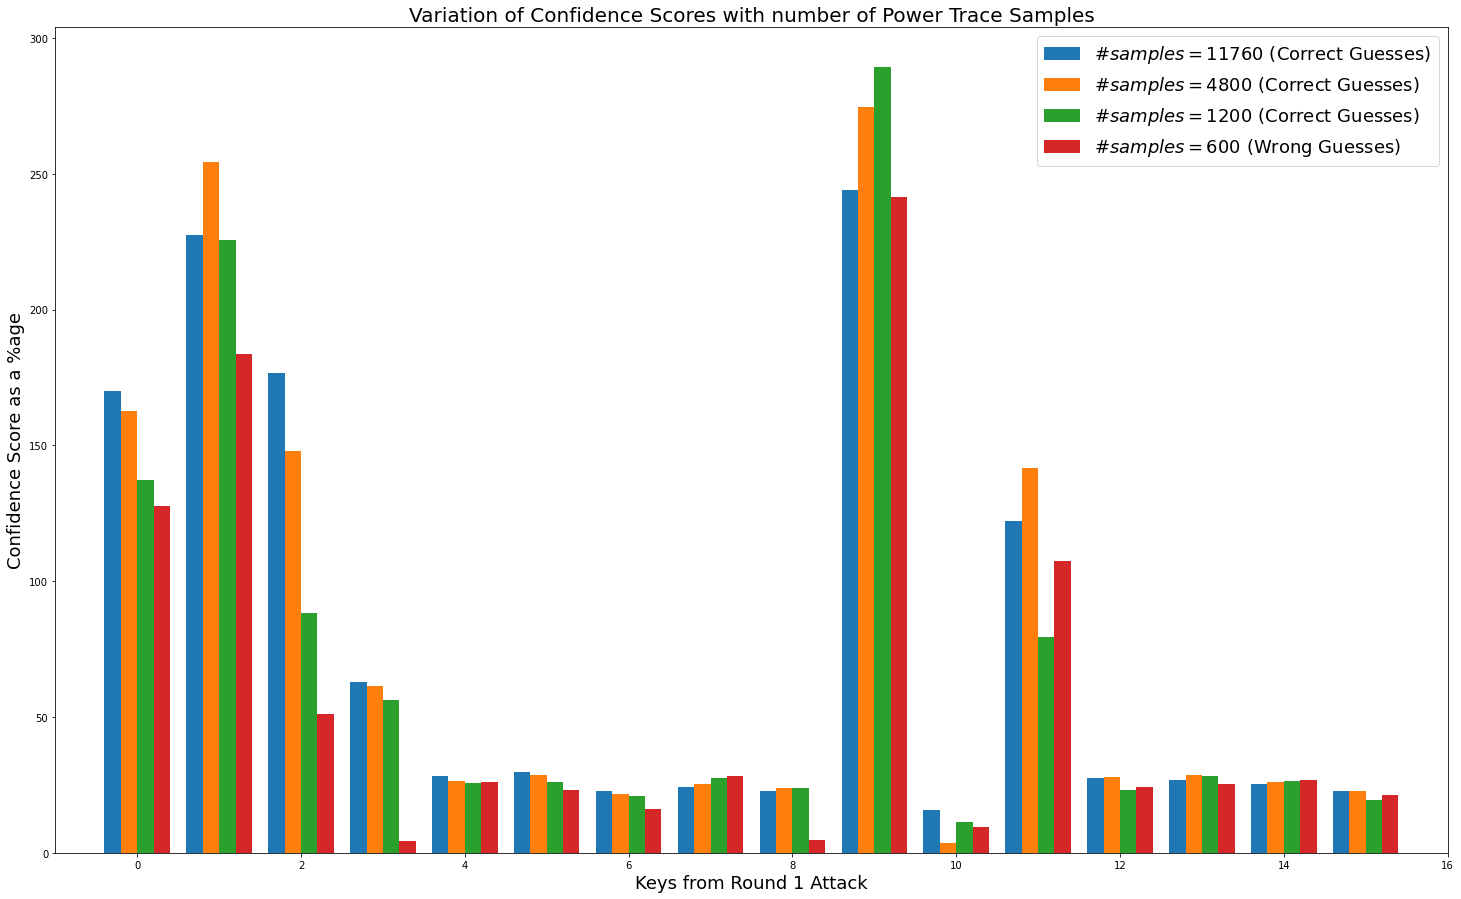

In [138]:
# Analyze Trace Number vs Conf Score: Plot for all 16 bytes and GMEAN5
'''
with open("../data/logs/confValpha.txt", "w") as f:
    for key, value in conf_v_alpha.items():
        f.write("%s: %s\n" % (key, value))
f.close()
'''
plotIdx = [0, 3, 5, 6]
alphaVec = []; confScoreVec = []
attackRnd = 1 if (attackType == "first") else 18
for i in plotIdx:
    alphaVec.append(conf_v_alpha["alpha"][i])
    confScoreVec.append(100 * (conf_v_alpha["scores"][i] - np.ones(16)))

x = np.arange(len(confScoreVec[0]))
fig, ax = plt.subplots(figsize= (20, 12))
bars0 = ax.bar(x - 0.3, confScoreVec[0], 0.2, label= r'$\# samples = {}$ (Correct Guesses)'.format(int(0.98*12000)))
bars1 = ax.bar(x - 0.1, confScoreVec[1], 0.2, label= r'$\# samples = {}$ (Correct Guesses)'.format(int(0.4*12000)))
bars2 = ax.bar(x + 0.1, confScoreVec[2], 0.2, label= r'$\# samples = {}$ (Correct Guesses)'.format(int(0.1*12000)))
bars3 = ax.bar(x + 0.3, confScoreVec[3], 0.2, label= r'$\# samples = {}$ (Wrong Guesses)'.format(int(0.05*12000)))

fig.tight_layout()
ax.set_ylabel("Confidence Score as a %age", fontsize= 18)
ax.set_xlabel("Keys (byte-positions) from Round {} Attack".format(attackRnd), fontsize= 18)
ax.set_xlim([-1, 16])
ax.legend(fontsize= 18)
ax.set_title("Variation of Confidence Scores with number of Power Trace Samples", fontsize= 20)
plt.show()

### Key Guesses:

The Key Guesses from the First and Last Round CPA attacks are:

|  | Byte 0 | Byte 1 | Byte 2 | Byte 3 |
|:---:|:---:|:---:|:---:|:---:|
| RK0 | 147<br>(0x93) | 125<br>(0x7D) | 184<br>(0xB8) | 242<br>(0xF2) |
| RK1 | 110<br>(0x6E) | 90<br>(0x5A) | 37<br>(0x25) | 172<br>(0xAC) |
| RK34 | 70<br>(0x46) | 245<br>(0xB5) | 112<br>(0xF8) | 168<br>(0xA8) |
| RK35 | 74<br>(0x4A) | 209<br>(0xD1) | 196<br>(0xC4) | 51<br>(0x33) |

The guesses have been saved to files in [this directory](https://github.com/aklsh/CS6630/tree/main/A2/data/keys) as well.

### Targeting the T-table outputs

Repeating attack taking the T table output as the intermediate result (for RK0 and RK1). 

We tried two attacks targeting T-tables, one that calculated the intermediate result as the XOR'd sums of the four T-tables (e.g. TF00 ^ TF01 ^ TF02 ^ TF03). In order to restrict the search space to 256 values (8-bits at a time), we split the 8 T-tables (four corresponding to F0 and four to F1) into 32 T-tables, with each table holding a byte of the result.

**Observations when T-tables stored 8-bits:**
- The guesses from this method seldom matches the guesses made by S-Box
- The max. correlation scores for this method was lower than that of the S-Box implementation
- Moreover, the confidence scores were much lower than that of the S-Box attack

Hence, we conclude that the intermediate results used here have relatively weaker artefacts in the power trace. We may require more sample traces to get better correlation scores. 

In [140]:
# Infer RK0/RK34:
# region to track in the power trace for artefacts from the 1st round

keyGuess = []
guessTop5 = []
confScore = []
printable = []

for i in tnrange(0, 4, desc="Attacking RK0"):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):
            if (i == 0):
                interVal = intermediate_00(textInp[traceNum, i], keyByte)
            elif (i == 1):
                interVal = intermediate_01(textInp[traceNum, i], keyByte)
            elif (i == 2):
                interVal = intermediate_02(textInp[traceNum, i], keyByte)
            elif (i == 3):
                interVal = intermediate_03(textInp[traceNum, i], keyByte)
            
            HWmatrix[traceNum, keyByte] = bin(interVal).count("1")

        for point in range(startPoint[offset], endPoint[offset]):
            hw = HWmatrix[:activeTraces, keyByte]
            trc = powerTrace[:activeTraces, point]
            corrScore[i, keyByte, point] = np.abs(linregress(hw, trc).slope)
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    # maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
#    clear_output(wait=True)  # clear the previous output
#    display(guessTop5)
#    display("Top-5 correlations for Byte {} at points: {}".format(i, corrScore[i].argmax(axis=1)[top5idx]))
#    display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))
        
    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()


    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status

display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

,0,1,2,3
0,0x930.003028,0xC30.002855,0xBF0.003141,0x5F0.002916
1,0x0B0.002560,0x230.002712,0xB70.002520,0x670.002781
2,0x7E0.002075,0x900.002680,0x9F0.002489,0xFE0.002611
3,0xE90.001884,0xF10.002656,0xA70.002418,0x850.002591
4,0xB40.001737,0x4A0.002572,0xE50.002168,0x4C0.002486


'Confidence Score: [1.1825224324888635, 1.052620978641287, 1.246385860532512, 1.0487679110792312]'

'Key Guesses: [147, 195, 191, 95]'

In [155]:
# Infer RK0/RK34:
# region to track in the power trace for artefacts from the 1st round

keyGuess = []
guessTop5 = []
confScore = []
printable = []

for i in tnrange(8, 12, desc="Attacking RK1"):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):
            if (i == 8):
                interVal = intermediate_10(textInp[traceNum, i], keyByte)
            elif (i == 9):
                interVal = intermediate_11(textInp[traceNum, i], keyByte)
            elif (i == 10):
                interVal = intermediate_12(textInp[traceNum, i], keyByte)
            elif (i == 11):
                interVal = intermediate_13(textInp[traceNum, i], keyByte)
            
            HWmatrix[traceNum, keyByte] = bin(interVal).count("1")

        for point in range(startPoint[offset], endPoint[offset]):
            hw = HWmatrix[:activeTraces, keyByte]
            trc = powerTrace[:activeTraces, point]
            corrScore[i, keyByte, point] = np.abs(linregress(hw, trc).slope)
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    # maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
#    clear_output(wait=True)  # clear the previous output
#    display(guessTop5)
#    display("Top-5 correlations for Byte {} at points: {}".format(i, corrScore[i].argmax(axis=1)[top5idx]))
#    display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))
        
    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()


    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status

display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

,0,1,2,3
0,0x6F0.000202,0xBC0.000238,0x290.000225,0x700.000196
1,0xFD0.000162,0x3C0.000222,0x590.000218,0xAC0.000192
2,0xB80.000153,0x620.000215,0x300.000217,0x8C0.000187
3,0xEF0.000152,0x4E0.000205,0xAF0.000216,0x600.000183
4,0xBB0.000149,0x880.000204,0x110.000201,0x830.000176


'Confidence Score: [1.2499634323844329, 1.06950676974477, 1.0337340538831905, 1.0200291063963165]'

'Key Guesses: [111, 188, 41, 112]'

The next variant that we tried was to evaluate the Intermediate Result as the 32-bit output of the T-table. For example, for byte 0, the intermediate result is taken as $TF_{00}\text{(guess-byte)}$.

**Observations when T-Tables stored 32-bit words:**
- In most cases, the Top-1 key guess of the S Box attack matches the Top-1 guess of the T Table Attack
- The correlation scores was higher here than the attack that used T-tables storing 8-bit words. However, the scores were lower than that of the S-Box attack
- The S Box attack gives a clearer distinguisher than the T Table attack
- In a couple of cases, the Top-1 key guesses differed. However, the Top-1 key guess of the S Box was present in the Top-5 guesses of the T Table attack. Further, the different between the correlation scores amongst the Top-5 guesses of the T Table was small.

We use these results to claim that the S-Box attack is the most resilient attack of the three that we tried.

In [142]:
keyGuess = []
guessTop5 = []
confScore = []
totTraces, numPoints = powerTrace.shape
alpha = 1.0
activeTraces = int(alpha * totTraces)
print(activeTraces)

# region to track in the power trace for artefacts from the 1st round
startPoint = 800
#winSize = 1000
#winStride = 1800
endPoint = 1200
'''
Bytes 0, 1, 2, 3:
StartPoint = 800
EndPoint = 1000 

Bytes 4-7, c-f:
StartPoint = 400
EndPoint = 800 

Bytes 8, 9, a, b:
StartPoint = 1100
EndPoint = 1400?
'''
HWmatrix = np.zeros((totTraces, 256), dtype= np.uint8)
corrScore = np.zeros((16, 256, numPoints))

12000


In [143]:
#for i in range(0, 16):
printable = []

for i in [0, 1, 2, 3, 8, 9, 10, 11]:
    temp = []
    for keyByte in tqdm(range(0, 256)):
        for traceNum in range(activeTraces):
            if (i == 0):  
                interVal = tf00(textInp[traceNum, i] ^ keyByte)
            elif (i == 1):
                interVal = tf01(textInp[traceNum, i] ^ keyByte)
            elif (i == 2):
                interVal = tf02(textInp[traceNum, i] ^ keyByte)
            elif (i == 3):
                interVal = tf03(textInp[traceNum, i] ^ keyByte)
            elif (i == 8):
                interVal = tf10(textInp[traceNum, i] ^ keyByte)
            elif (i == 9):
                interVal = tf11(textInp[traceNum, i] ^ keyByte)
            elif (i == 10):
                interVal = tf12(textInp[traceNum, i] ^ keyByte)
            elif (i == 11):
                interVal = tf13(textInp[traceNum, i] ^ keyByte)
            else:
                interVal = intermediate_xor(textInp[traceNum, i], keyByte)
            #HWmatrix[traceNum, keyByte] = HW[interVal]
            HWmatrix[traceNum, keyByte] = bin(interVal).count("1")
       
        #for tracePoint in range(startPoint + i*winStride, startPoint + i*winStride + winSize):
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint:endPoint]
        corrScore[i, keyByte, startPoint:endPoint] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint - startPoint)]
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
#    clear_output(wait=True)  # clear the previous output
#    display(guessTop5)
#    display("Top-5 correlations for Byte {} at points: {}".format(i, corrScore[i].argmax(axis=1)[top5idx]))
#    display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status

display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

,0,1,2,3,4,5,6,7
0,0x930.000885,0x7D0.001287,0xF70.001267,0xF20.001053,0x6E0.000955,0x5A0.001402,0x5C0.001131,0xAC0.002193
1,0x880.000662,0xE20.000963,0xB80.001238,0x8E0.001001,0x8A0.000918,0x1A0.001401,0x580.000938,0x4C0.001221
2,0x460.000635,0x560.000938,0xA00.000997,0x6B0.000877,0xC00.000887,0x440.001278,0x250.000931,0xD70.001217
3,0x070.000632,0xCF0.000926,0xAC0.000910,0xEB0.000866,0x400.000867,0x8F0.000990,0xAD0.000919,0x320.001203
4,0x940.000629,0x810.000869,0x600.000907,0x850.000827,0xB60.000853,0x280.000958,0x3D0.000896,0x090.001196


'Confidence Score: [1.3369366184015197, 1.335970244131087, 1.0232654245667625, 1.0524818624489094, 1.0396094334233623, 1.0004498697612723, 1.2053337124264385, 1.7959669981156288]'

'Key Guesses: [147, 125, 247, 242, 110, 90, 92, 172]'

### Second Round Attack

In order to extract $RK_2 \oplus WK_0$ and $RK_3 \oplus WK_1$, we perform CPA on the second round of encryption. We repeat the same three choices of intermediate results here. 

In [144]:
# CPA at T-table output:
def tf00(inp):
    return tf00Arr[inp]

def tf01(inp):
    return tf01Arr[inp]

def tf02(inp):
    return tf02Arr[inp]

def tf03(inp):
    return tf03Arr[inp]

def tf10(inp):
    return tf10Arr[inp]

def tf11(inp):
    return tf11Arr[inp]

def tf12(inp):
    return tf12Arr[inp]

def tf13(inp):
    return tf13Arr[inp]

def f0(inpBytes, keyBytes):
    return tf00(inpBytes[0] ^ keyBytes[0]) ^ tf01(inpBytes[1] ^ keyBytes[1]) ^ tf02(inpBytes[2] ^ keyBytes[2]) ^ tf03(inpBytes[3] ^ keyBytes[3])

def f1(inpBytes, keyBytes):
    return tf10(inpBytes[0] ^ keyBytes[0]) ^ tf11(inpBytes[1] ^ keyBytes[1]) ^ tf12(inpBytes[2] ^ keyBytes[2]) ^ tf13(inpBytes[3] ^ keyBytes[3])

rk0 = np.load("../data/keys/RK0.npy", "r")
rk1 = np.load("../data/keys/RK1.npy", "r")
wk0 = np.load("../data/keys/WK0_probable.npy", "r")
wk1 = np.load("../data/keys/WK1_probable.npy", "r")
wk2 = np.load("../data/keys/WK2_probable.npy", "r")
wk3 = np.load("../data/keys/WK3_probable.npy", "r")

def intermediate_rk2(pt0Bytes, rk0Bytes, pt1Byte, bytePos):
    return (f0(pt0Bytes, rk0Bytes) >> bytePos) & (0xFF) ^ pt1Byte

def intermediate_rk3(pt2Bytes, rk1Bytes, pt3Byte, bytePos):
    return (f1(pt2Bytes, rk1Bytes) >> bytePos) & (0xFF) ^ pt3Byte


In [145]:
keyGuess = []
guessTop5 = []
confScore = []
totTraces, numPoints = powerTrace.shape
alpha = 1.0
activeTraces = int(alpha * totTraces)
print(activeTraces)

# region to track in the power trace for artefacts from the 1st round
startPoint = 1450
endPoint = 1800

HWmatrix = np.zeros((totTraces, 256), dtype= np.uint8)
corrScore = np.zeros((16, 256, numPoints))

12000


### S-Box output as Intermediate Result

In [146]:
printable = []
for i in range(0, 4):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):

            inp_to_SBox = intermediate_rk2(textInp[traceNum, 0:4], rk0, textInp[traceNum, 4+i], 8 * i)
            #
            if (i % 2 == 0):
                interVal = intermediate_0(inp_to_SBox, keyByte)
            else:
                interVal = intermediate_1(inp_to_SBox, keyByte)
            HWmatrix[traceNum, keyByte] = HW[interVal]
        
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint:endPoint]
        corrScore[i, keyByte, startPoint:endPoint] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint - startPoint)]
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
#    clear_output(wait=True)  # clear the previous output
#    display(guessTop5)
#    display("Top-5 correlations for Byte {} at points: {}".format(i, corrScore[i].argmax(axis=1)[top5idx]))
#    display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status

display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))    

,0,1,2,3
0,0xBF0.000509,0x040.000549,0x400.000544,0x520.000606
1,0xA10.000474,0x8E0.000549,0xD80.000486,0xDB0.000545
2,0x090.000469,0x690.000547,0xEC0.000482,0xAF0.000453
3,0x890.000464,0x230.000532,0x0C0.000458,0x780.000446
4,0x6E0.000456,0xBE0.000489,0xDE0.000449,0x6A0.000431


'Confidence Score: [1.073462157435103, 1.0014095366280842, 1.1199769129967154, 1.1120213015202964]'

'Key Guesses: [191, 4, 64, 82]'

In [147]:
printable = []
for i in range(8, 12):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):

            inp_to_SBox = intermediate_rk3(textInp[traceNum, 8:12], rk1, textInp[traceNum, 4+i], 8 * (i - 8))
            #
            if (i % 2 == 0):
                interVal = intermediate_1(inp_to_SBox, keyByte)
            else:
                interVal = intermediate_0(inp_to_SBox, keyByte)
            HWmatrix[traceNum, keyByte] = HW[interVal]
        
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint:endPoint]
        corrScore[i, keyByte, startPoint:endPoint] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint - startPoint)]
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
#    clear_output(wait=True)  # clear the previous output
#    display(guessTop5)
#    display("Top-5 correlations for Byte {} at points: {}".format(i, corrScore[i].argmax(axis=1)[top5idx]))
#    display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()


    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status

display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

,0,1,2,3
0,0xFB0.000513,0x810.000699,0x8E0.000621,0xB10.000630
1,0x110.000502,0xFF0.000566,0x1E0.000555,0x980.000550
2,0xE20.000493,0x750.000560,0x990.000500,0xB30.000499
3,0xF10.000473,0xB60.000539,0x6E0.000482,0xDC0.000499
4,0x8B0.000450,0x5F0.000510,0x9E0.000447,0x400.000492


'Confidence Score: [1.073462157435103, 1.0014095366280842, 1.1199769129967154, 1.1120213015202964, 1.0206439706586024, 1.2343822708557328, 1.1189473974809565, 1.1465473462958837]'

'Key Guesses: [191, 4, 64, 82, 251, 129, 142, 177]'

### T-Table Output as Intermediate Result

**Using 8 T-Tables (storing 32-bit words):**

In [148]:
keyGuess = []
guessTop5 = []
confScore = []
printable = []

for i in range(0, 4):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):

            inp_to_SBox = intermediate_rk2(textInp[traceNum, 0:4], rk0, textInp[traceNum, 4+i], 8 * i)
            #
            if (i == 0):  
                interVal = tf00(inp_to_SBox ^ keyByte)
            elif (i == 1):
                interVal = tf01(inp_to_SBox ^ keyByte)
            elif (i == 2):
                interVal = tf02(inp_to_SBox ^ keyByte)
            elif (i == 3):
                interVal = tf03(inp_to_SBox ^ keyByte)
            HWmatrix[traceNum, keyByte] = bin(interVal).count("1")
        
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint:endPoint]
        corrScore[i, keyByte, startPoint:endPoint] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint - startPoint)]
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
#    clear_output(wait=True)  # clear the previous output
#    display(guessTop5)
#    display("Top-5 correlations for Byte {} at points: {}".format(i, corrScore[i].argmax(axis=1)[top5idx]))
#    display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status

display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

,0,1,2,3
0,0x980.000175,0x680.000244,0x060.000237,0x170.000214
1,0x7B0.000157,0x2B0.000232,0x390.000213,0x100.000199
2,0x7F0.000157,0xC20.000214,0x720.000203,0x8B0.000195
3,0x140.000151,0x9C0.000208,0xB60.000200,0xEE0.000183
4,0x030.000150,0x140.000206,0x890.000198,0x880.000176


'Confidence Score: [1.1149063724390984, 1.0499257691344255, 1.110562686800982, 1.075703533450398]'

'Key Guesses: [152, 104, 6, 23]'

In [152]:
keyGuess = []
guessTop5 = []
confScore = []
printable = []

for i in range(8, 12):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):

            inp_to_SBox = intermediate_rk3(textInp[traceNum, 8:12], rk1, textInp[traceNum, 4+i], 8 * (i-8))
            #
            if (i == 8):  
                interVal = tf10(inp_to_SBox ^ keyByte)
            elif (i == 9):
                interVal = tf11(inp_to_SBox ^ keyByte)
            elif (i == 10):
                interVal = tf12(inp_to_SBox ^ keyByte)
            elif (i == 11):
                interVal = tf13(inp_to_SBox ^ keyByte)
            HWmatrix[traceNum, keyByte] = bin(interVal).count("1")
        
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint:endPoint]
        corrScore[i, keyByte, startPoint:endPoint] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint - startPoint)]
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
#    clear_output(wait=True)  # clear the previous output
#    display(guessTop5)
#    display("Top-5 correlations for Byte {} at points: {}".format(i, corrScore[i].argmax(axis=1)[top5idx]))
#    display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status

display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

,0,1,2,3
0,0x9F0.000250,0x6F0.000254,0x060.000192,0xA80.000205
1,0x360.000230,0xE80.000254,0xC80.000192,0x600.000197
2,0x650.000214,0xDE0.000236,0xA80.000181,0x160.000184
3,0xDB0.000191,0x790.000211,0xE80.000179,0x700.000177
4,0x2E0.000188,0x460.000208,0xF20.000175,0x2A0.000174


'Confidence Score: [1.084079563645664, 1.0021172765022934, 1.002822184719627, 1.0418678256075529]'

'Key Guesses: [159, 111, 6, 168]'

**Using 32 T-Tables (storing 8-bit words):**

In [149]:
keyGuess = []
guessTop5 = []
confScore = []
printable = []

for i in range(0, 4):
    temp = []
    for keyByte in tnrange(0, 256, desc="Generating Hamming Weights"):
        for traceNum in range(activeTraces):

            inp_to_SBox = intermediate_rk2(textInp[traceNum, 0:4], rk0, textInp[traceNum, 4+i], 8 * i)
            #
            if (i == 0):
                interVal = intermediate_00(inp_to_SBox, keyByte)
            elif (i == 1):
                interVal = intermediate_01(inp_to_SBox, keyByte)
            elif (i == 2):
                interVal = intermediate_02(inp_to_SBox, keyByte)
            elif (i == 3):
                interVal = intermediate_03(inp_to_SBox, keyByte)
            HWmatrix[traceNum, keyByte] = bin(interVal).count("1")
        
        hwvec = HWmatrix[:activeTraces, keyByte]
        pTrace = powerTrace[:activeTraces, startPoint:endPoint]
        corrScore[i, keyByte, startPoint:endPoint] = [np.abs(linregress(hwvec, pTrace[:, point]).slope) \
                                                      for point in range(endPoint - startPoint)]
        temp.append((keyByte, np.max(corrScore[i, keyByte])))

    maxScoreVec = corrScore[i].max(axis=1)    #maxScore across tracePoints for each guess
    top5idx = maxScoreVec.argsort()[-5:]
    confScore.append(maxScoreVec[top5idx][-1] / maxScoreVec[top5idx][-2])
    guessTop5.append(("Byte Number: {}".format(i), "Top-5 Indices: {}".format(top5idx), "Top-5 Corr Scores: {}".format(maxScoreVec[top5idx])))
    keyGuess.append(top5idx[-1])
    
#    clear_output(wait=True)  # clear the previous output
#    display(guessTop5)
#    display("Top-5 correlations for Byte {} at points: {}".format(i, corrScore[i].argmax(axis=1)[top5idx]))
#    display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

    temp.sort(key = lambda x: -x[1])  # sort temp by dom value
    printable.append(temp)  # add the data in list
    df = pd.DataFrame(printable).transpose()

    clear_output(wait=True)  # clear the previous output
    display(df.head().style.format(format_stat).apply(color_corr_key, axis=0))  # display the current status

display("Confidence Score: {}".format(confScore), "Key Guesses: {}".format(keyGuess))

,0,1,2,3
0,0x140.000613,0x140.000609,0xE70.000627,0xF40.000592
1,0x210.000534,0x5A0.000592,0x7B0.000565,0x260.000557
2,0x700.000528,0x190.000576,0x620.000497,0xFF0.000542
3,0x4A0.000513,0x0C0.000530,0x680.000491,0x9F0.000527
4,0x040.000511,0xEF0.000489,0xFE0.000476,0x9E0.000482


'Confidence Score: [1.1494278775181954, 1.028054183391046, 1.1097135652257089, 1.06254835264006]'

'Key Guesses: [20, 20, 231, 244]'

**Key Observations:**
- The correlation scores are lower across the board for all three methods
- The confidence scores are not large enough to indicate a strong distinguisher
- The key guesses of the S-Box attack and the two T-table attacks do not match

**Key Insights:**
- The power artefacts in the second round are weak
- Requires a search over $3^{8}$ probable key sequences to arrive at the correct sequence (3 probable values per byte)
- The probable whitenining key values can be used to reduce the search space. As the round keys are derived from the whitenining keys, only a few byte sequences of $RK_2 \oplus WK_0$ and $RK_3 \oplus WK_1$ are plausible. This however requires a brute force search over $2^{16}$ possible whitening key sequences.